In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

In [63]:
# https://www.kaggle.com/datasets/erenaktas/human-activity-recognition
# https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

df = pd.read_csv(
    'UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt',
    header=None,
    delim_whitespace=True,
)

In [64]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [65]:
df.shape

(7352, 128)

In [10]:
df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
123    float64
124    float64
125    float64
126    float64
127    float64
Length: 128, dtype: object

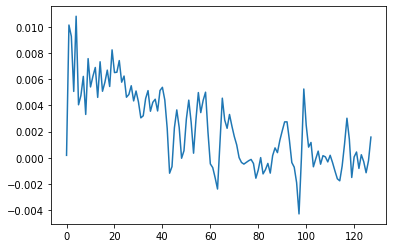

In [11]:
df.iloc[0].plot();

In [12]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [15]:
def load_data():
    # Returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))

    # train load_data
    ts_filenames = [
        'body_acc_x_train.txt','body_acc_y_train.txt','body_acc_z_train.txt',
        'body_gyro_x_train.txt','body_gyro_y_train.txt','body_gyro_z_train.txt',
        'total_acc_x_train.txt','total_acc_y_train.txt','total_acc_z_train.txt'
    ]

    ts_file_prefix = 'UCI HAR Dataset/train/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header=None,
            delim_whitespace=True
        )

        # Ntrain x T array
        x = df.to_numpy()
        Xtrain[:,:,d] = x

    # train labels
    Ytrain = pd.read_csv(
        f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
    Ytrain = Ytrain.flatten()

    # test load_data
    ts_filenames = [
        'body_acc_x_test.txt','body_acc_y_test.txt','body_acc_z_test.txt',
        'body_gyro_x_test.txt','body_gyro_y_test.txt','body_gyro_z_test.txt',
        'total_acc_x_test.txt','total_acc_y_test.txt','total_acc_z_test.txt'
    ]

    ts_file_prefix = 'UCI HAR Dataset/test/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header=None,
            delim_whitespace=True
        )

        # Ntrain x T array
        x = df.to_numpy()
        Xtest[:,:,d] = x

    # test labels
    Ytest = pd.read_csv(
        f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
    Ytest = Ytest.flatten()

    return Xtrain, Ytrain, Xtest, Ytest

In [16]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

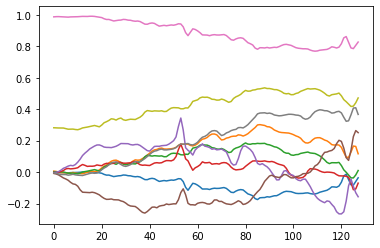

In [17]:
plt.plot(Xtrain[7000,:,:]);

In [18]:
# ANN
inputs = []
features = []

# make a neural network for each of the D time series
for d in range(D):
    i = Input(shape=(T,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    inputs.append(i)
    features.append(x)

# output of concatenate will be D * (size of individual ANN output)
x = Concatenate()(features)
x= Dense(K)(x)
model = Model(inputs, x)

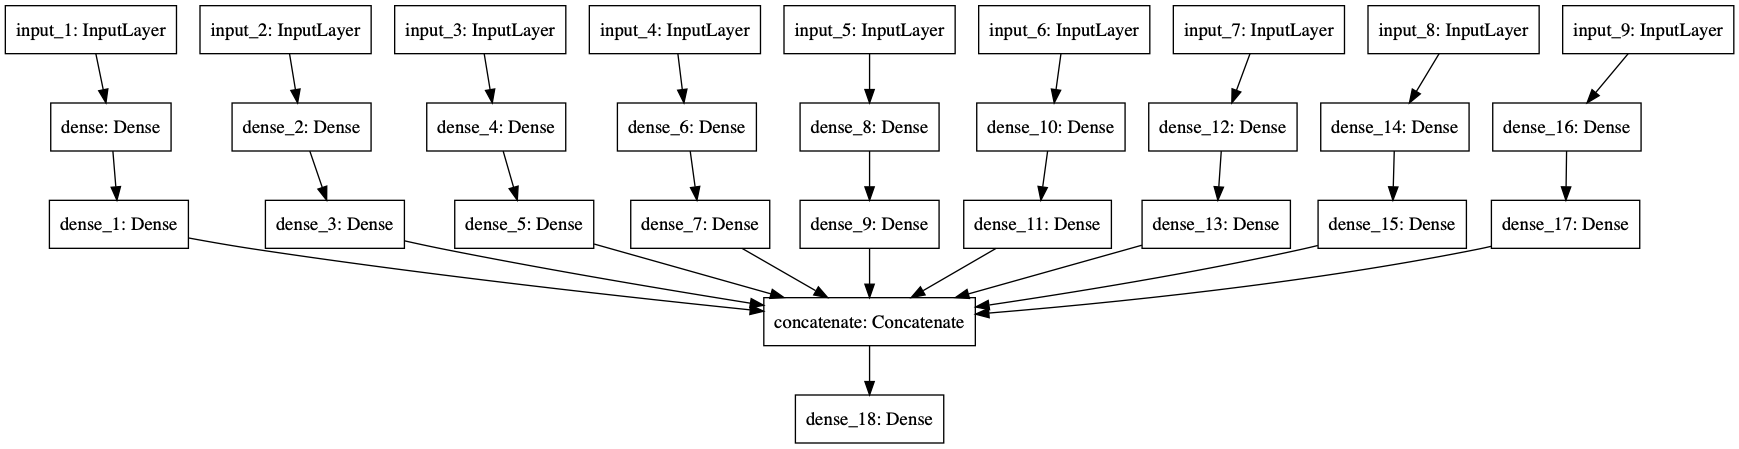

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True
)

In [21]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

In [22]:
Xtrain_split = []
Xtest_split = []
for d in range(D):
    Xtrain_split.append(Xtrain[:,:,d])
    Xtest_split.append(Xtest[:,:,d])

In [23]:
r = model.fit(
    Xtrain_split,
    Ytrain,
    epochs=15,
    callbacks=[check_point],
    validation_data=(Xtest_split, Ytest)
)

Epoch 1/15
230/230 [==============================] - 1s 4ms/step - loss: 0.6250 - accuracy: 0.7811 - val_loss: 0.4589 - val_accuracy: 0.8354
Epoch 2/15
230/230 [==============================] - 1s 3ms/step - loss: 0.2212 - accuracy: 0.9244 - val_loss: 0.3667 - val_accuracy: 0.8738
Epoch 3/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1606 - accuracy: 0.9470 - val_loss: 0.3432 - val_accuracy: 0.8816
Epoch 4/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1340 - accuracy: 0.9506 - val_loss: 0.3228 - val_accuracy: 0.8951
Epoch 5/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1175 - accuracy: 0.9591 - val_loss: 0.2928 - val_accuracy: 0.9040
Epoch 6/15
230/230 [==============================] - 1s 4ms/step - loss: 0.1051 - accuracy: 0.9623 - val_loss: 0.3105 - val_accuracy: 0.8938
Epoch 7/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0962 - accuracy: 0.9667 - val_loss: 0.3068 - val_accuracy: 0.8999
Epoch 

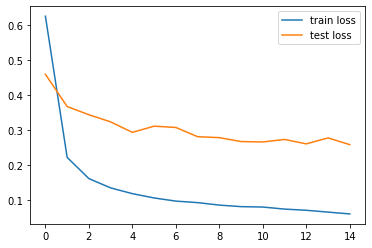

In [24]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

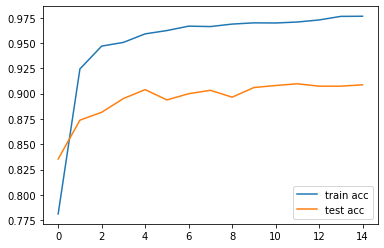

In [25]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [26]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [27]:
# make predictions
Ptest = best_model.predict(Xtest_split)

In [30]:
from sklearn.preprocessing import StandardScaler

def load_features():
    # Returns:
    # X_train (Ntrain x D)
    # X test (Xtest x D)

    # train data
    df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True
    )

    feat_train = df.to_numpy()

    # test data
    df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True
    )

    feat_test = df.to_numpy()

    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.fit_transform(feat_test)

    return feat_train, feat_test

In [31]:
feat_train, feat_test = load_features()

In [32]:
D_feat = feat_train.shape[1]

In [33]:
# Basic ANN
i = Input(shape=(D_feat,))
x = Dense(32, activation='relu')(i)
x = Dense(K)(x)
model = Model(i,x)

In [34]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

In [35]:
check_point2 = ModelCheckpoint(
    'best_model_basic.h5', monitor='val_accuracy', save_best_only=True
)

In [36]:
r = model.fit(
    feat_train,
    Ytrain,
    epochs=15,
    callbacks=[check_point2],
    validation_data=(feat_test, Ytest)
)

Epoch 1/15
230/230 [==============================] - 0s 2ms/step - loss: 0.3325 - accuracy: 0.8762 - val_loss: 0.1907 - val_accuracy: 0.9342
Epoch 2/15
230/230 [==============================] - 0s 1ms/step - loss: 0.1084 - accuracy: 0.9630 - val_loss: 0.1413 - val_accuracy: 0.9484
Epoch 3/15
230/230 [==============================] - 0s 874us/step - loss: 0.0764 - accuracy: 0.9732 - val_loss: 0.1361 - val_accuracy: 0.9444
Epoch 4/15
230/230 [==============================] - 0s 975us/step - loss: 0.0602 - accuracy: 0.9781 - val_loss: 0.1415 - val_accuracy: 0.9467
Epoch 5/15
230/230 [==============================] - 0s 947us/step - loss: 0.0507 - accuracy: 0.9837 - val_loss: 0.1458 - val_accuracy: 0.9457
Epoch 6/15
230/230 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.1353 - val_accuracy: 0.9535
Epoch 7/15
230/230 [==============================] - 0s 1ms/step - loss: 0.0403 - accuracy: 0.9871 - val_loss: 0.1765 - val_accuracy: 0.9416


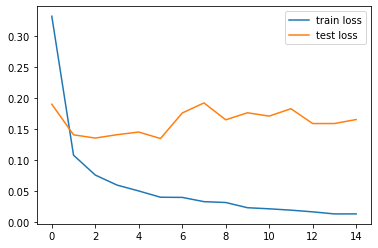

In [37]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

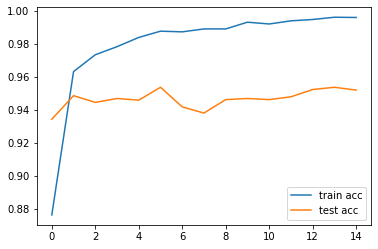

In [38]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [39]:
# load best model
best_model = tf.keras.models.load_model('best_model_basic.h5')

In [40]:
# make predictions
Ptest = best_model.predict(feat_test)

In [41]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9535120461486257

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [43]:
model = LogisticRegression(
    solver='liblinear'
)
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

0.9945593035908596

In [44]:
model.score(feat_test, Ytest)

0.9643705463182898

In [45]:
model = SVC()
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

0.9866702937976061

In [46]:
model.score(feat_test, Ytest)

0.9565659993213438

In [47]:
model = SVC(kernel='linear')
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

0.9968715995647442

In [48]:
model.score(feat_test, Ytest)

0.9623345775364778

In [49]:
model = RandomForestClassifier()
model.fit(feat_train, Ytrain)
model.score(feat_train, Ytrain)

1.0

In [50]:
model.score(feat_test, Ytest)

0.9172039362063115

In [51]:
# Combined model
inputs = []
features = []

# make a neural network for each of the D time series
for d in range(D):
    i = Input(shape=(T,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    inputs.append(i)
    features.append(x)

i2 = Input(shape=(D_feat,))
x2 = Dense(32, activation='relu')(i2)

# output of concatenate will be D * (size of individual ANN output)
x = Concatenate()(features + [x2])
x = Dense(K)(x)
model = Model(inputs + [i2], x)

In [52]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

In [53]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor='val_accuracy',save_best_only=True
)

In [54]:
r = model.fit(
    Xtrain_split + [feat_train],
    Ytrain,
    epochs=15,
    callbacks=[check_point3],
    validation_data=(Xtest_split + [feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 2s 7ms/step - loss: 0.2857 - accuracy: 0.9019 - val_loss: 0.2319 - val_accuracy: 0.9206
Epoch 2/15
230/230 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9701 - val_loss: 0.1733 - val_accuracy: 0.9406
Epoch 3/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.9747 - val_loss: 0.1700 - val_accuracy: 0.9393
Epoch 4/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.9789 - val_loss: 0.1860 - val_accuracy: 0.9365
Epoch 5/15
230/230 [==============================] - 1s 2ms/step - loss: 0.0499 - accuracy: 0.9812 - val_loss: 0.1489 - val_accuracy: 0.9491
Epoch 6/15
230/230 [==============================] - 1s 2ms/step - loss: 0.0397 - accuracy: 0.9863 - val_loss: 0.1625 - val_accuracy: 0.9501
Epoch 7/15
230/230 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9883 - val_loss: 0.1827 - val_accuracy: 0.9467
Epoch 

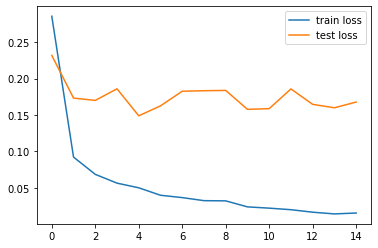

In [55]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

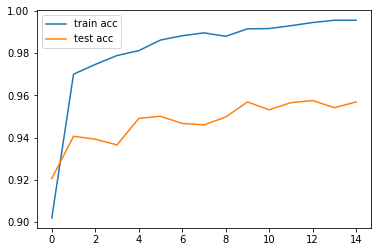

In [56]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [57]:
# load best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [59]:
# make predictions
Ptest = best_model.predict(Xtest_split + [feat_test])

In [60]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9575839837122497